<a href="https://colab.research.google.com/github/satoshi19989/transformer_practice/blob/main/transformer_time_series2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!apt-get install git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.25.1-1ubuntu3.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [4]:
!git clone https://github.com/satoshi19989/transformer_practice.git

Cloning into 'transformer_practice'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 32 (delta 14), reused 22 (delta 9), pack-reused 0
Unpacking objects: 100% (32/32), 122.27 KiB | 1.82 MiB/s, done.


In [5]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [6]:
module_path = "/content/transformer_practice/modules"
sys.path.append(module_path)

# 対象データ確認

In [7]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-02-22 22:59:53--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.128.152, 52.216.48.192, 52.216.60.248, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.128.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  40.6MB/s    in 0.3s    

2023-02-22 22:59:54 (40.6 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [8]:
#例１

fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))


#例2

# data_path = os.path.join(module_path, "influenza_transformer/data")
# data = pd.read_csv(os.path.join(data_path, "dfs_merged_upload.csv"), index_col=0)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


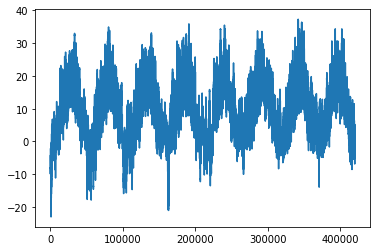

In [9]:
from matplotlib import pyplot as plt

#例1
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

plt.plot(range(len(temperature)), temperature)


#例2
# plt.figure()
# plt.plot(data['FCR_N_PriceEUR'])

# データ前処理

In [ ]:
import generate_data as gd
import utility
from utility import resampling



#例1
#raw_data = resampling(raw_data, 6)
batch_size = 256
window_width =120
pred_points = 24

#例2
# raw_data = data['FCR_N_PriceEUR'].values
# raw_data = raw_data[:-1925]

# batch_size = 100
# window_width =20
# pred_points = 10

predata = gd.PreprocessData(raw_data, batch_size, window_width, pred_points, 6, 1)

# 学習用データ生成

In [109]:
from generate_data import textbook_method, textbook_method_multistep

# sampling_rate = 6
# sequence_length = 120
# pred_points = 10
# delay = sampling_rate * (sequence_length + 24 - 1)
# batch_size = 256

sampling_rate = 1
sequence_length = 120
pred_points = 10
delay = sampling_rate * (sequence_length +  - 1)
batch_size = 256

#train_dataset, val_dataset, test_dataset = textbook_method(raw_data, temperature, sampling_rate, sequence_length, delay, batch_size)
train_dataset, val_dataset, test_dataset, mean, std = textbook_method_multistep(raw_data, temperature, sampling_rate, sequence_length, delay, pred_points, batch_size)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


/content/transformer_practice/modules/generate_data.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  start_index=0,


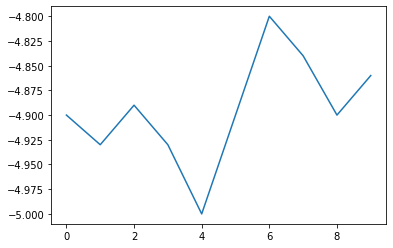

In [90]:
plt.figure()
plt.plot(temperature[delay:delay+10])

In [67]:
mean

array([-1.60029757e-17,  4.03804842e-17,  4.78976011e-16, -3.24310814e-17,
       -2.76933905e-16,  4.89195238e-17,  6.82072229e-17,  2.22282255e-18,
       -4.34611716e-16,  3.03650552e-16, -3.35811108e-17, -4.10892102e-17,
        3.32267874e-16, -3.55975737e-17])

(256, 129, 14) => (256, 10)


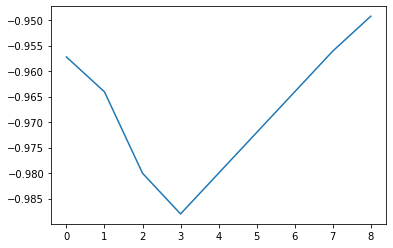

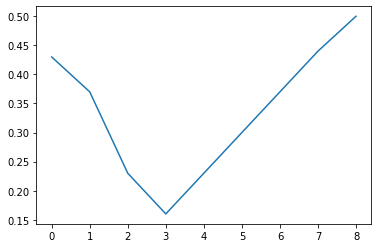

In [113]:
for x,y in train_dataset:
    #x, y = train_dataset[i]
    print('%s => %s' % (x.shape, y.shape))
    enc_input = x[:,:sequence_length]
    dec_input = x[:,sequence_length-1:]

    plt.figure()
    plt.plot(dec_input[0,1:,1])

    plt.figure()
    plt.plot(y[0,:-1])
    break

In [ ]:
#transformerの場合
enc_train, dec_train, y_train, enc_val, dec_val, y_val, enc_test, dec_test, y_test = predata.make_data_for_transformer()
input = tf.concat([enc_train, dec_train], axis=1)
val_input = tf.concat([enc_val, dec_val], axis=1)
val_data = (val_input, y_val)

#NNの場合
x_train, y_train, x_val, y_val, x_test, y_test = predata.make_data_for_NN()



input_train  (34816, 120, 14)
y_train  (34816,)
input_val  (17408, 120, 14)
y_val  (17408,)
input_test  (17152, 120, 14)
y_test  (17152,)


In [ ]:
import utility

train_data = raw_data[:predata.num_train_samples]
val_data = raw_data[predata.num_train_samples : predata.num_train_samples+predata.num_val_samples]
test_data = raw_data[predata.num_train_samples + predata.num_val_samples : predata.num_train_samples + predata.num_val_samples + predata.num_test_samples]

test_mae, y_pred_naive = utility.evaluate_naive_method(test_data)

#print(f"Validation MAE: {evaluate_naive_method(val_data):.2f}")
print(f"Test MAE: {test_mae:.2f}")

Test MAE: 2.38


# 基本的なNNを試す

In [ ]:
from tensorflow.python import metrics
from tensorflow import keras
from tensorflow.keras import layers

class MyLayer(tf.keras.layers.Layer):
  def __init__(self, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
      super().__init__(trainable, name, dtype, dynamic, **kwargs)

      self.flat = layers.Flatten()
      self.layer1 = layers.Dense(16, activation="relu")
      self.layer2 = layers.Dense(1)

  def call(self, x):
    print(x.shape)
    x = self.flat(x)
    x = self.layer1(x)
    x = self.layer2(x)
    return x

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# x = layers.Flatten()(inputs)
# x = layers.Dense(16, activation="relu")(x)
# outputs = layers.Dense(1)(x)
outputs = MyLayer()(inputs)
model = keras.Model(inputs, outputs)

#callbackを使って最も性能の良いモデルを保存
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# history = model.fit(x_train, 
#                     y_train, 
#                     epochs=10,
#                     #batch_size=batch_size, 
#                     validation_data=(x_val, y_val),
#                     callbacks=callbacks)

history = model.fit(train_dataset, 
                    epochs=10,
                    batch_size=batch_size, 
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_dense.keras", custom_objects={'MyLayer':MyLayer})

print(f"Test MAE: {model.evaluate(x_test, y_test)[1]:.2f}")

(None, 120, 14)
Epoch 1/10
(None, 120, 14)
(None, 120, 14)
819/819 [==============================] - 58s 69ms/step - loss: 11.8802 - mae: 2.6696 - val_loss: 10.9544 - val_mae: 2.6091
Epoch 2/10
819/819 [==============================] - 56s 69ms/step - loss: 8.7167 - mae: 2.3203 - val_loss: 10.5987 - val_mae: 2.5671
Epoch 3/10
819/819 [==============================] - 58s 70ms/step - loss: 8.0300 - mae: 2.2254 - val_loss: 10.7199 - val_mae: 2.5914
Epoch 4/10
819/819 [==============================] - 55s 67ms/step - loss: 7.6188 - mae: 2.1682 - val_loss: 11.3213 - val_mae: 2.6626
Epoch 5/10
819/819 [==============================] - 55s 67ms/step - loss: 7.3211 - mae: 2.1259 - val_loss: 11.3968 - val_mae: 2.6609
Epoch 6/10
819/819 [==============================] - 57s 70ms/step - loss: 7.1142 - mae: 2.0958 - val_loss: 10.4062 - val_mae: 2.5446
Epoch 7/10
819/819 [==============================] - 58s 70ms/step - loss: 6.9464 - mae: 2.0699 - val_loss: 10.9125 - val_mae: 2.6128
Epoch 

ValueError: ignored

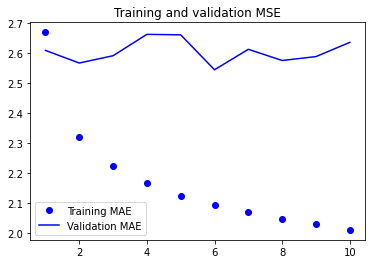

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MSE")
plt.legend()
plt.show()

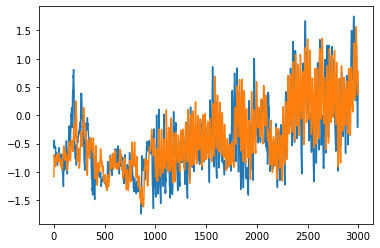

In [ ]:
end_point = 3000

plt.figure()
plt.plot(y_test[:end_point])
plt.plot(y_pred[:end_point,0])

In [ ]:
MSE, r2 = utility.calc_score(y_test, y_pred[:,0])
print("MSE : ", MSE)
print("r2 : ", r2)

MSE :  0.38244757104208854
r2 :  0.8241300222865205


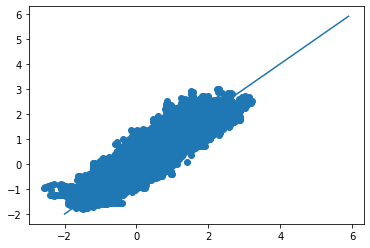

In [ ]:
x = np.arange(-2, 6, 0.1)
y = x

plt.figure()
plt.scatter(y_test, y_pred[:,0])
plt.plot(x, y)

# トランスフォーマの構築

In [114]:
dmodel = 28

In [115]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from transformer_layers import Encoder
import transformer_core as tfc
from transformer_core import TransformerBaseTimeSeriesForecastModel, EncoderWithMultiHeadAttentionBaseTimeSeriesForecastModel

# 学習率を返す関数を用意する
def lr_schedul(epoch):
    lr = (dmodel**0.5) * min(epoch**0.5, epoch * (5000**(-1.5)))
    return lr


lr_decay = LearningRateScheduler(
    lr_schedul,
    # verbose=1で、更新メッセージ表示。0の場合は表示しない
    verbose=0,
)

criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-09, amsgrad=False)


# inputs = keras.Input(shape=(None,))
# x = Encoder(4, dmodel, 1, 100, sequence_length, 20000, 0.2)(x, True, None)  # (batch_size, inp_seq_len, d_model)
# outputs = layers.Dense(1)(x)

# model = keras.Model(inputs, outputs)





inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
inputs = keras.Input(shape=(sequence_length+pred_points -1, raw_data.shape[-1]))

# outputs = EncoderWithMultiHeadAttentionBaseTimeSeriesForecastModel(num_layers=1, # Multi-head Attentionの繰り返し数
#                                                   d_model = dmodel, # embeddingの次元
#                                                   num_heads=1,  # Multi-head Attentionのヘッド数
#                                                   dff = 30,      #全結合層のユニット数
#                                                   pe_input = sequence_length, 
#                                                   window_width = sequence_length, 
#                                                   rate=0.2)(inputs)
                                 
outputs = TransformerBaseTimeSeriesForecastModel(num_layers=2, # Multi-head Attentionの繰り返し数
                                                  d_model = dmodel, # embeddingの次元
                                                  num_heads=2,  # Multi-head Attentionのヘッド数
                                                  dff = 30,      #全結合層のユニット数
                                                  pe_input = sequence_length, 
                                                  pe_target = pred_points,
                                                  window_width = sequence_length, 
                                                  rate=0.2)(inputs)

model = keras.Model(inputs, outputs)


#model.build(input_shape=(batch_size, sequence_length, 14))
model.compile(loss=criterion, optimizer=optimizer, metrics=['mae'])




In [116]:
model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 129, 14)]         0         
                                                                 
 transformer_base_time_serie  (None, 10, 1)            34141     
 s_forecast_model_14 (Transf                                     
 ormerBaseTimeSeriesForecast                                     
 Model)                                                          
                                                                 
Total params: 34,141
Trainable params: 34,141
Non-trainable params: 0
_________________________________________________________________


In [117]:
# input = tf.concat([enc_train, dec_train], axis=1)
# val_input = tf.concat([enc_val, dec_val], axis=1)
# val_data = (val_input, y_val)

# print(val_input.shape, y_val.shape)

#callbackを使って最も性能の良いモデルを保存
callbacks = [
    lr_decay
    #, keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]
#history=model.fit(input, y_train, batch_size=batch_size, epochs=10, validation_data=val_data, callbacks=callbacks,verbose=2)
history=model.fit(train_dataset, batch_size=batch_size, epochs=10, validation_data=val_dataset, callbacks=callbacks,verbose=2)
# model = keras.models.load_model("jena_dense.keras", 
#                                 custom_objects={"EncoderWithMultiHeadAttentionBaseTimeSeriesForecastModel":EncoderWithMultiHeadAttentionBaseTimeSeriesForecastModel})

Epoch 1/10
821/821 - 1096s - loss: 172.1900 - mae: 10.8741 - val_loss: 184.9323 - val_mae: 11.3039 - lr: 0.0000e+00 - 1096s/epoch - 1s/step
Epoch 2/10
821/821 - 1097s - loss: 105.3062 - mae: 8.2010 - val_loss: 60.2131 - val_mae: 5.8332 - lr: 1.4967e-05 - 1097s/epoch - 1s/step
Epoch 3/10
821/821 - 1145s - loss: 50.1745 - mae: 5.0766 - val_loss: 41.8311 - val_mae: 4.4148 - lr: 2.9933e-05 - 1145s/epoch - 1s/step
Epoch 4/10
821/821 - 1117s - loss: 35.6231 - mae: 3.9197 - val_loss: 30.2290 - val_mae: 3.3860 - lr: 4.4900e-05 - 1117s/epoch - 1s/step
Epoch 5/10
821/821 - 1137s - loss: 23.1336 - mae: 2.9204 - val_loss: 17.2984 - val_mae: 2.2850 - lr: 5.9867e-05 - 1137s/epoch - 1s/step
Epoch 6/10
821/821 - 1146s - loss: 12.0859 - mae: 1.9379 - val_loss: 7.4072 - val_mae: 1.2672 - lr: 7.4833e-05 - 1146s/epoch - 1s/step
Epoch 7/10
821/821 - 1103s - loss: 4.6384 - mae: 1.1620 - val_loss: 2.2383 - val_mae: 0.7057 - lr: 8.9800e-05 - 1103s/epoch - 1s/step
Epoch 8/10
821/821 - 1103s - loss: 1.5567 - ma

In [118]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

411/411 [==============================] - 162s 393ms/step - loss: 0.3816 - mae: 0.4446
Test MAE: 0.44


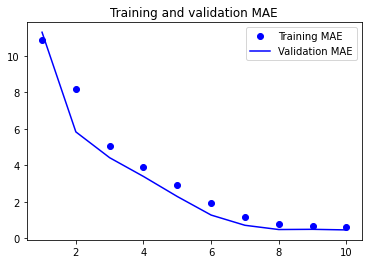

In [119]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

samples shape: (256, 129, 14)
targets value: (256, 10)
8/8 [==============================] - 0s 58ms/step
preds value: (256, 10, 1)


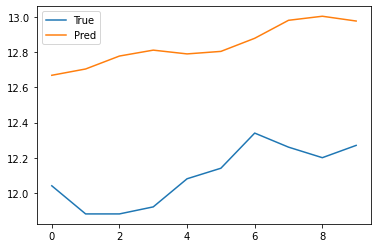

In [133]:
for samples, targets in test_dataset:
    print("samples shape:", samples.shape)
    print("targets value:", targets.shape)
    targets_pred = model.predict(samples)
    print("preds value:", targets_pred.shape)  

    plt.figure()
    plt.plot(targets[0], label="True")
    plt.plot(targets_pred[0,:,0], label="Pred")
    plt.legend()
    plt.show()
    break

In [ ]:
y_test.shape

TensorShape([17152, 24])

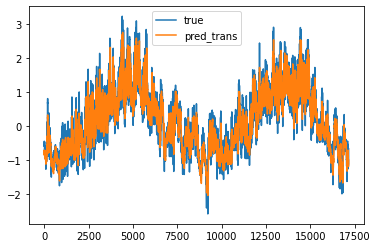

In [ ]:
start_point = 0
end_point = 30000

plt.figure()
plt.plot(y_test[start_point:end_point,-1], label="true")
plt.plot(y_pred[start_point:end_point,-1,0], label="pred_trans")
#plt.plot(y_pred_naive[start_point+29 : end_point+29], label="naive")
plt.legend()

In [ ]:

MSE, r2 = utility.calc_score(y_test[:,-1], y_pred[:,-1,0])
print(MSE, r2)

0.20853984289677904 0.9477040455568707


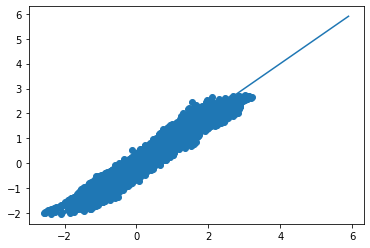

In [ ]:
x = np.arange(-2, 6, 0.1)
y = x

plt.figure()
plt.scatter(y_test[:,-1], y_pred[:,-1,0])
plt.plot(x, y)

# 教科書の実装

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [ ]:
from transformer_layers import positional_encoding

# vocab_size = 20000
# embed_dim = 256
# num_heads = 2
# dense_dim = 32

pos_encoding = positional_encoding(20000, dmodel)

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(sequence_length, dmodel)(inputs)
#x = inputs + pos_encoding[:, :sequence_length, :]
x = TransformerEncoder(dmodel, 100, 1)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss=criterion, optimizer=optimizer, metrics=['mae'])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 16)          1920      
                                                                 
 transformer_encoder_63 (Tra  (None, None, 16)         4468      
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_2 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_137 (Dropout)       (None, 16)                0         
                                                                 
 dense_177 (Dense)           (None, 1)                 17  

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder})
print(f"Test acc: {model.evaluate(test_dataset)[1]:.3f}")

Epoch 1/20


ValueError: ignored